In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/finaldatasets.csv')

data.shape

(400, 5)

In [ ]:
# Convert the "Time" to datetime and set as index
data['Time'] = pd.to_datetime(data['Time'] + '-1', format='%Y-w%W-%w')

data.head()

,Time,Rainfall,Temperature,Humidity,Cases
0,2016-01-04,0.034,28.100000,81.671429,19
1,2016-01-11,0.000,28.310000,81.685714,23
2,2016-01-18,0.000,28.033333,80.400000,31
3,2016-01-25,0.420,26.527778,85.985714,26
4,2016-02-01,5.660,27.444440,84.680000,10


In [ ]:
# Select features for normalization (excluding the target column)
features = data[['Rainfall', 'Temperature','Humidity']]
target = data['Cases']

features.shape, target.shape

((400, 3), (400,))

In [ ]:
# Normalize the features and target using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

normalized_features = scaler_features.fit_transform(features)
normalized_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Convert back to DataFrame for better manipulation
normalized_data = pd.DataFrame(normalized_features, columns=features.columns, index=data.index)
normalized_data['Cases'] = normalized_target

In [ ]:
normalized_data.head()

,Rainfall,Temperature,Humidity,Cases
0,0.001941,0.457173,0.485102,0.059561
1,0.000000,0.497644,0.486034,0.072100
2,0.000000,0.444325,0.402235,0.097179
3,0.023973,0.154176,0.766294,0.081505
4,0.323059,0.330834,0.681192,0.031348


In [ ]:
# Function to create sequences for LSTM
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [ ]:
# Prepare the sequences using the past 10 months of data
window_size = 10
X, y = create_sequences(normalized_data.values, normalized_target, window_size)

In [ ]:
# Split into training and testing sets (80% training, 20% testing)
split_index = int(len(X) * 0.85)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((331, 10, 4), (59, 10, 4), (331, 1), (59, 1))

In [ ]:
# Define the LSTM model with Input layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))  # Output layer to predict dengue cases

In [ ]:
# Compile the model with Adam optimizer and custom learning rate
learning_rate = 0.0001  # Custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0307 - val_loss: 0.0253
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0137 - val_loss: 0.0199
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0144 - val_loss: 0.0194
Epoch 4/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0106 - val_loss: 0.0162
Epoch 5/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0063 - val_loss: 0.0151
Epoch 6/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0050 - val_loss: 0.0135
Epoch 7/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0050 - val_loss: 0.0135
Epoch 8/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0036 - val_loss: 0.0116
Epoch 9/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0055 - val_loss: 0.0120
Epoch 10/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 11/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 12/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/ste

In [ ]:
y_train_pred = model.predict(X_train)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# Rescale back to the original dengue case values
predicted_actual_scale_train = scaler_target.inverse_transform(y_train_pred)
y_train_actual_scale_train = scaler_target.inverse_transform(y_train)

In [ ]:
# Compute MSE and RMSE
mse = mean_squared_error(y_train_actual_scale_train, predicted_actual_scale_train)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 125.1248938817829
RMSE: 11.185923917217696


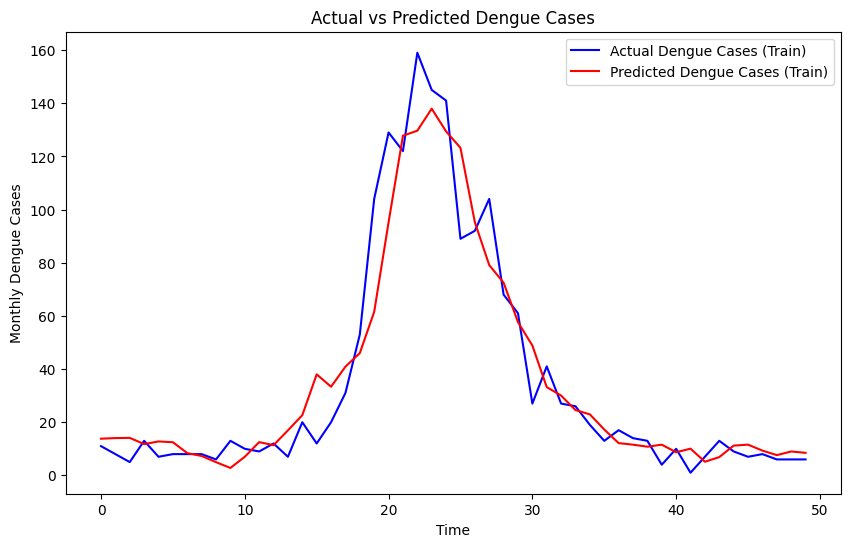

In [ ]:
# Plot the actual vs predicted dengue cases
plt.figure(figsize=(10, 6))
plt.plot(y_train_actual_scale_train[:50], label='Actual Dengue Cases (Train)', color='blue')
plt.plot(predicted_actual_scale_train[:50], label='Predicted Dengue Cases (Train)', color='red')
plt.title('Actual vs Predicted Dengue Cases')
plt.xlabel('Time')
plt.ylabel('Monthly Dengue Cases')
plt.legend()
plt.show()

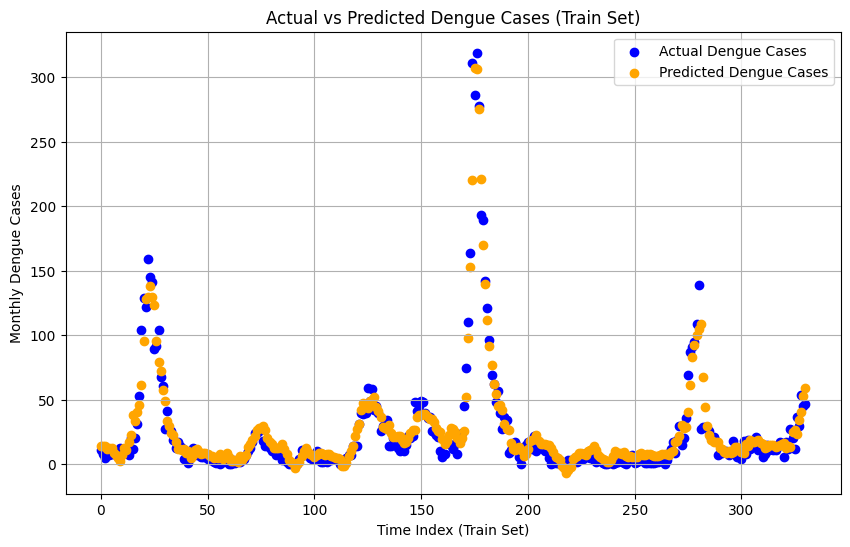

In [ ]:
# Plot: Actual vs Predicted values with different colors
plt.figure(figsize=(10, 6))

# Plot actual values
plt.scatter(np.arange(len(y_train_actual_scale_train)), y_train_actual_scale_train, color='blue', label='Actual Dengue Cases')

# Plot predicted values
plt.scatter(np.arange(len(predicted_actual_scale_train)), predicted_actual_scale_train, color='orange', label='Predicted Dengue Cases')

# Add title and labels
plt.title('Actual vs Predicted Dengue Cases (Train Set)')
plt.xlabel('Time Index (Train Set)')
plt.ylabel('Monthly Dengue Cases')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Set a threshold for classification (you can adjust this threshold based on domain knowledge)
threshold = 0.5

# Binarize the predicted values
y_train_pred_class = (predicted_actual_scale_train >= threshold).astype(int)
y_train_actual_class = (y_train_actual_scale_train >= threshold).astype(int)

# Compute classification metrics
accuracy = accuracy_score(y_train_actual_class, y_train_pred_class)
precision = precision_score(y_train_actual_class, y_train_pred_class)
recall = recall_score(y_train_actual_class, y_train_pred_class)

# Display metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9365558912386707
Precision: 0.953416149068323
Recall: 0.9808306709265175


# Test Data

In [ ]:
# Predictions
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [ ]:
# Rescale back to the original dengue case values
predicted_actual_scale = scaler_target.inverse_transform(y_pred)
y_test_actual_scale = scaler_target.inverse_transform(y_test)

In [ ]:
# Compute MSE and RMSE
mse = mean_squared_error(y_test_actual_scale, predicted_actual_scale)
rmse = np.sqrt(mse)

In [ ]:
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 447.8911168149141
RMSE: 21.16343820873428


In [ ]:
print(predicted_actual_scale.shape)
print(y_test_actual_scale.shape)

(59, 1)
(59, 1)


In [ ]:
predicted_actual_scale = predicted_actual_scale.flatten()
y_test_actual_scale = y_test_actual_scale.flatten()

In [ ]:
# intialise data of lists.
results = pd.DataFrame({'Predicted Cases': pd.Series(predicted_actual_scale),
                        'Actual Cases': pd.Series(y_test_actual_scale)})

results.head()

,Predicted Cases,Actual Cases
0,58.570507,28.0
1,46.352936,40.0
2,41.691444,41.0
3,41.571323,42.0
4,44.190281,22.0


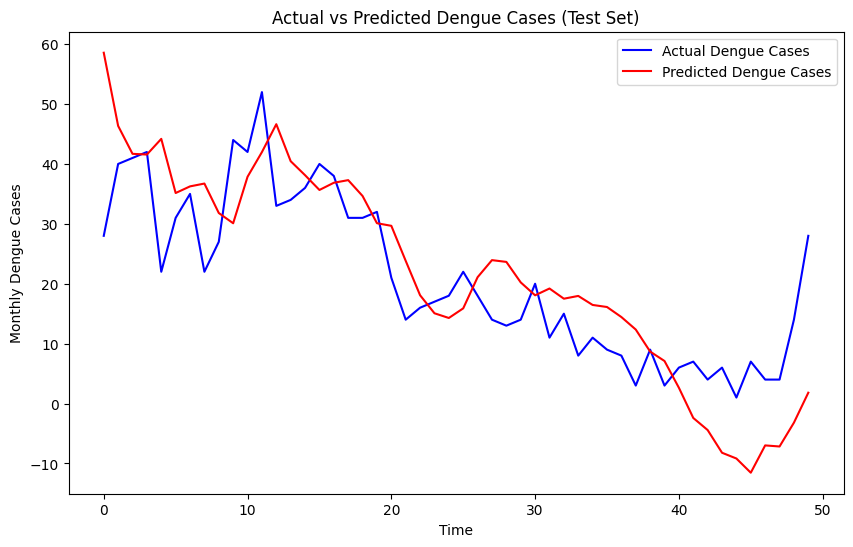

In [ ]:
# Plot the actual vs predicted dengue cases
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_scale[:50], label='Actual Dengue Cases', color='blue')
plt.plot(predicted_actual_scale[:50], label='Predicted Dengue Cases', color='red')
plt.title('Actual vs Predicted Dengue Cases (Test Set)')
plt.xlabel('Time')
plt.ylabel('Monthly Dengue Cases')
plt.legend()
plt.show()

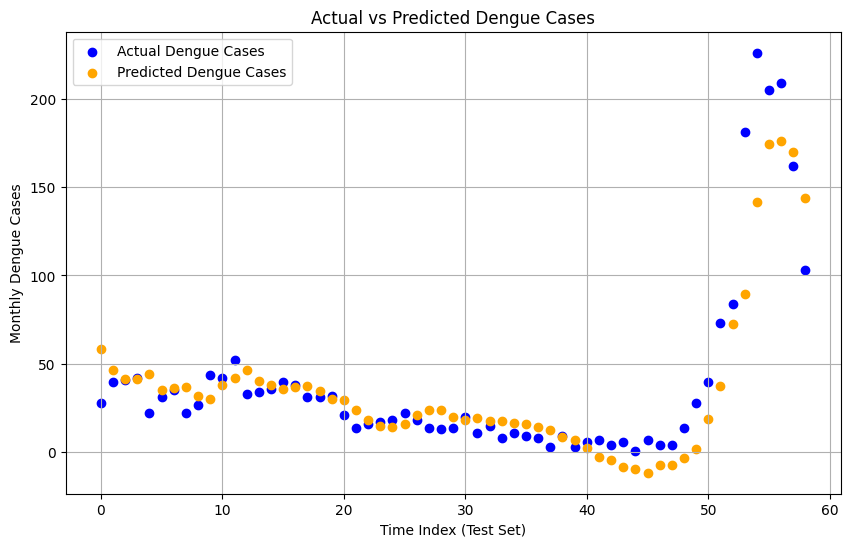

In [ ]:
# Plot: Actual vs Predicted values with different colors
plt.figure(figsize=(10, 6))

# Plot actual values
plt.scatter(np.arange(len(y_test_actual_scale)), y_test_actual_scale, color='blue', label='Actual Dengue Cases')

# Plot predicted values
plt.scatter(np.arange(len(predicted_actual_scale)), predicted_actual_scale, color='orange', label='Predicted Dengue Cases')

# Add title and labels
plt.title('Actual vs Predicted Dengue Cases')
plt.xlabel('Time Index (Test Set)')
plt.ylabel('Monthly Dengue Cases')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Set a threshold for classification (you can adjust this threshold based on domain knowledge)
threshold = 0.5

# Binarize the predicted values
y_test_pred_class = (predicted_actual_scale >= threshold).astype(int)
y_test_actual_class = (y_test_actual_scale >= threshold).astype(int)

# Compute classification metrics
accuracy_test = accuracy_score(y_test_actual_class, y_test_pred_class)
precision_test = precision_score(y_test_actual_class, y_test_pred_class)
recall_test = recall_score(y_test_actual_class, y_test_pred_class)

# Display metrics
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")

Accuracy: 0.864406779661017
Precision: 1.0
Recall: 0.864406779661017
